# Make tables: calculate p-values and differential expressions for each cancer 

Create a dataframe with p-value results from t-tests for all proteins. The dataframe also includes the change in medians between missense mutation and wildtype. Prepare these tables for further analysis by creating csv files.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
'''
Params
all_prot: list of trans genes
utils: from cptac

Returns a dataframe with trans proteomics and mutation status (KRAS missense or wt)
'''

def all_prot_format_df(cancer_object, all_prot, gene_in = 'KRAS', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    # Keep only tumor samples from proteomics
    prot_and_mutations = cancer_object.join_omics_to_mutations(
        mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot,
        tissue_type = 'tumor') # drop Normal samples
        
    # Reduce a multiindex 
    if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
        prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1) 

    # Merge Mutation column from get_genotype_all_vars with proteomics
   
    mut_type = mut_type[['Mutation']] 
    mut_type["Mutation"] = mut_type['Mutation'].replace(['nonsynonymous SNV'], 'Missense_Mutation')#for colon
    prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
    merged = prot_df.join(mut_type)
        
    # Keep only Wildtype and Missense
    compare = ['Wildtype_Tumor','Missense_Mutation']
    get = merged['Mutation'].isin(compare)
    missense_wt = merged[get]
    return missense_wt
 


In [4]:
'''
Params
cancer_object: Object. Variable for the loaded cancer data set.
cancer_name: Str. name to add to the created dataframe.
del_wt_df: DataFrame. Only samples with deletions and wildtype for PIK3CA. 
all_prot_list: List. All proteins in proteomics data frame. 

Returns a dataframe with the difference in medians between proteomics with PIK3CA wt and del (wt - Missense). 
'''

def get_change_in_medians_df(cancer_object, cancer_name, miss_wt_df, all_prot_list):
    m = miss_wt_df[miss_wt_df.Mutation == "Missense_Mutation"]
    wt = miss_wt_df[miss_wt_df.Mutation == "Wildtype_Tumor"]
    miss_med = m.median()
    wt_med = wt.median()

    med_dict = {}
    
    # Correlation: + is mutant up compared to wt, - is mutant down
    for prot in all_prot_list:
        if prot in miss_med.index and prot in wt_med.index:
            dif = miss_med[prot] - wt_med[prot]
            med_dict[prot] = dif
        
    df = pd.DataFrame.from_dict(med_dict, orient='index', columns=[cancer_name+'_Median'])
    df = df.reset_index().rename(columns={'index':'Proteomics'})
    
    return df
        

#  Step 1: Create data frames with p-values and differential expressions

Each cancer needs a data frame containing only samples that have PTEN cnv deletions and PTEN wildtype with trans proteomics. Use wrap_ttest to run t-tests for all genes in the proteomic data frame. Use get_change_in_medians_df to create the data frame with differential expression values. Merge both data frames. 

Load in cancer data sets from cptac. 

In [5]:

en = cptac.Endometrial()
col = cptac.Colon()
luad = cptac.Luad()

# Colon

Part 1: Format data frame using all_prot_format_df. This returns a dataframe with proteomics and a Mutation column containing only PTEN cnv deletions and wildtype tumors. 

In [6]:
gene = 'KRAS'
col_prot = col.get_proteomics()
col_prot = col_prot.drop(columns = 'KRAS') # cis effect
col_prot_list = list(col_prot.columns)

col_miss_wt = all_prot_format_df(col, col_prot_list)
col_miss_wt.head()


Name,A1BG_proteomics,A1CF_proteomics,A2M_proteomics,AAAS_proteomics,AACS_proteomics,AAGAB_proteomics,AAK1_proteomics,AAMDC_proteomics,AAMP_proteomics,AAR2_proteomics,...,ZNRD1_proteomics,ZNRF2_proteomics,ZPR1_proteomics,ZRANB2_proteomics,ZW10_proteomics,ZWILCH_proteomics,ZWINT_proteomics,ZYX_proteomics,ZZEF1_proteomics,Mutation
Patient_ID,,,,,,,,,,,,,,,,,,,,,
01CO001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wildtype_Tumor
01CO006,-1.120,-0.441,-0.347,-0.0029,0.0957,0.3960,-0.0363,-0.549,0.220,0.248,...,0.324,NaN,-0.3940,0.0846,0.001,-0.345,NaN,-0.658,0.0052,Wildtype_Tumor
01CO008,-1.200,0.160,-1.850,0.1190,-0.0924,0.0187,-0.2140,0.328,-0.282,-0.348,...,NaN,-0.3840,-0.1680,0.3570,-0.325,0.349,NaN,-0.821,0.2000,Missense_Mutation
01CO013,-1.890,0.112,-0.329,0.6700,0.1160,0.3130,-0.2380,-0.274,-0.554,0.270,...,NaN,NaN,-0.0656,-0.2950,0.463,-0.448,0.0493,-0.904,-0.1580,Wildtype_Tumor
01CO014,-0.523,-0.248,-0.638,0.2890,0.3780,0.8220,0.0018,-1.080,0.498,-0.120,...,NaN,0.0467,0.2170,0.2360,0.287,0.346,NaN,-0.812,-0.0273,Wildtype_Tumor


Part 2: Run T-tests. Create a data frame of just significant comparisons and another data frame for all comparisons. A moderately stringent correction is used (FDR_BH).

In [7]:
col_cols = list(col_miss_wt.columns[:-1])

# Get all pvals
col_pval = u.wrap_ttest(col_miss_wt, 'Mutation', col_cols, return_all = True, correction_method = 'fdr_bh', mincount = 5, pval_return_corrected=True)
col_pval = col_pval.rename(columns = {'Comparison': 'Proteomics','P_Value': 'Colon_P_Value'})

Part 3: Create the differential expression df. (median of tumors with KRAS wildtype - median of tumors with KRAS missense mutation)

In [8]:
col_med = get_change_in_medians_df(col, "Colon", col_miss_wt, col_cols)




Part 4: Merge the p-value and differential expression dfs.

In [9]:
col_merged = col_pval.merge(col_med, on='Proteomics', how='outer')
col_merged = col_merged.replace(to_replace = r'_proteomics', value = '', regex = True)

# Create csv
#en_merged.to_csv('csv/Single_Cancer/Gbm_pval_medians.csv',index=False)
col_merged.head()

,Proteomics,Colon_P_Value,Colon_Median
0,TSPAN8,0.299150,0.5515
1,LY6E,0.374324,-1.0160
2,CMAS,0.452723,0.3137
3,IL33,0.452723,0.5955
4,HPGDS,0.452723,0.5835


# Repeat for other cancers.

In [10]:
cancer_objects = { 'Luad':luad, 'Endo':en}

In [11]:
import warnings
warnings.filterwarnings('ignore')

gene = 'PIK3CA'
merged_dfs = {}
for cancer in cancer_objects:
    prot = cancer_objects[cancer].get_proteomics()
    prot = prot.drop(columns = 'PIK3CA') # cis effect
    
    # Reduce a multiindex 
    if isinstance(prot.keys(), pd.core.indexes.multi.MultiIndex):
        prot = u.reduce_multiindex(prot, levels_to_drop = 1)
    prot_list = list(prot.columns)
    
    # Format df for t-test
    miss_wt = all_prot_format_df(cancer_objects[cancer], prot_list)
    
    # Rename duplicate columns (isoforms)
    col_names = pd.Series(miss_wt.columns[:])
    for dup in col_names[col_names.duplicated()].unique(): 
        col_names[col_names[col_names == dup].index.values.tolist()] = [dup + '_isoform_' + str(i) if i != 0 else dup for i in range(sum(col_names == dup))]
    miss_wt.columns = col_names # rename the columns with the cols list
    
    # T-test
    cols_in = list(miss_wt.columns[:-1])

    # Get all pvals
    min_num = 5
    all_pval = u.wrap_ttest(miss_wt, 'Mutation', cols_in, return_all = True, correction_method = 'fdr_bh', mincount = min_num, pval_return_corrected=True)
    all_pval = all_pval.rename(columns = {'Comparison': 'Proteomics','P_Value': cancer+'_P_Value'})
    
    # Get difference in medians
    delta_median_df = get_change_in_medians_df(cancer_objects[cancer], cancer, miss_wt, cols_in)

    # Merge pval_df and delta_median_df
    pval_medians_df = all_pval.merge(delta_median_df, on='Proteomics', how='outer')
    pval_medians_df = pval_medians_df.replace(to_replace = r'_proteomics', value = '', regex = True)
    merged_dfs[cancer] = pval_medians_df # testing purposes
    
    # Create csv
    #pval_medians_df.to_csv('csv/Single_Cancer/'+cancer+'_pval_medians.csv', index=False)
    print(pval_medians_df.head(), '\n')

  Proteomics  Luad_P_Value  Luad_Median
0      DOCK5      0.001950      1.09795
1      TUFT1      0.002112      1.60680
2         F3      0.003637      2.78775
3     CYP4X1      0.004582     -2.68340
4       MPP6      0.008484     -1.22155 

  Proteomics  Endo_P_Value  Endo_Median
0      SPRY1      0.001049      0.86320
1  TNFRSF12A      0.032985      0.55361
2    ZFYVE19      0.032985      0.28900
3     GPRC5A      0.032985      1.14670
4      SPRY4      0.035016      0.61115 



# Get number of significant genes in each cancer

In [12]:
# Add colon to merged_dfs dictionary
merged_dfs['Colon'] = col_merged


In [13]:
# Using corrected pvals from wrap_ttest, each cancer's cutoff is 0.05
all_sig = []

for cancer in merged_dfs:
    df = merged_dfs[cancer]
    sig_df = df.loc[df[cancer+'_P_Value'] < 0.05]
    print(cancer, 'sig comparisons:', len(sig_df))
    sig_list = list(sig_df['Proteomics'])
    all_sig.append(sig_list)
        

flat_list = [item for sublist in all_sig for item in sublist] #change list of lists, to just one list
sig = list(set(flat_list)) # keep only one if gene in multiple cancer sig lists
print('\nNumber of significant comparisons in at least 1 cancer:', len(sig))

Luad sig comparisons: 23
Endo sig comparisons: 6
Colon sig comparisons: 0

Number of significant comparisons in at least 1 cancer: 29


In [14]:
# check

In [15]:
# check

# Get a list of significant genes in at least one cancer

In [16]:
s = pd.Series(sig)
print('Number of significant genes in at least one cancer:', len(s))
#s.to_csv('csv/list_sig_one_cancer.csv', index=False)

Number of significant genes in at least one cancer: 29


In [17]:
Luad_results = merged_dfs["Luad"]

Luad_sig_df = Luad_results.loc[Luad_results['Luad_P_Value'] < 0.05]
Luad_sig_df

,Proteomics,Luad_P_Value,Luad_Median
0,DOCK5,0.001950,1.09795
1,TUFT1,0.002112,1.60680
2,F3,0.003637,2.78775
3,CYP4X1,0.004582,-2.68340
4,MPP6,0.008484,-1.22155
5,FAM83A,0.012118,3.05200
6,RAP1GAP2,0.013942,1.83630
7,ERI3,0.013942,-0.62310
8,LCOR,0.013942,1.19465
9,CD74_isoform_1,0.013942,-2.36095


In [68]:
Luad_sig_df = Luad_results.loc[Luad_results['Proteomics'] == "SLK"]
Luad_sig_df

,Proteomics,Luad_P_Value,Luad_Median
229,SLK,0.129044,0.32215


# Check Single Proteins boxplot

In [58]:
prot = luad.get_proteomics( tissue_type = 'tumor')
prot = prot[["SLK"]]
prot = u.reduce_multiindex(prot, levels_to_drop = 1) 
mut_type = luad.get_genotype_all_vars("KRAS")
merged = prot.merge(mut_type, on='Patient_ID', how='left')
merged.head()

Name,SLK,SLK,Mutation,Location,Mutation_Status
Patient_ID,,,,,
C3L-00001,-0.9599,0.7064,Amplification,Amplification,Single_mutation
C3L-00009,0.0230,0.4575,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00080,-1.4957,-2.4115,Deletion,Deletion,Single_mutation
C3L-00083,-0.1969,-4.2566,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00093,-0.0774,0.1494,Deletion,Deletion,Single_mutation


In [62]:
col_names = pd.Series(merged.columns[:])
for dup in col_names[col_names.duplicated()].unique(): 
    col_names[col_names[col_names == dup].index.values.tolist()] = [dup + '_isoform_' + str(i) if i != 0 else dup for i in range(sum(col_names == dup))]
merged.columns = col_names # rename the columns with the cols list
merged = merged.drop(columns = "SLK_isoform_1")
merged

Name,SLK,Mutation,Location,Mutation_Status
Patient_ID,,,,
C3L-00001,-0.9599,Amplification,Amplification,Single_mutation
C3L-00009,0.0230,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00080,-1.4957,Deletion,Deletion,Single_mutation
C3L-00083,-0.1969,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00093,-0.0774,Deletion,Deletion,Single_mutation
...,...,...,...,...
C3N-02729,-0.7610,Amplification,Amplification,Single_mutation
X11LU013,0.5913,Wildtype_Tumor,No_mutation,Wildtype_Tumor
X11LU016,-0.4730,Wildtype_Tumor,No_mutation,Wildtype_Tumor


In [66]:
compare = ['Wildtype_Tumor','Missense_Mutation']
get = merged['Mutation'].isin(compare)
missense_wt = merged[get]
hotspots = ["p.G12C","p.G12V","No_mutation"]
get = missense_wt['Location'].isin(hotspots)
missense_wt = missense_wt[get]
missense_wt

Name,SLK,Mutation,Location,Mutation_Status
Patient_ID,,,,
C3L-00009,0.0230,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00083,-0.1969,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00095,-0.1628,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00140,-0.8556,Wildtype_Tumor,No_mutation,Wildtype_Tumor
C3L-00144,-0.5029,Wildtype_Tumor,No_mutation,Wildtype_Tumor
...,...,...,...,...
C3N-02588,-0.8182,Wildtype_Tumor,No_mutation,Wildtype_Tumor
X11LU013,0.5913,Wildtype_Tumor,No_mutation,Wildtype_Tumor
X11LU016,-0.4730,Wildtype_Tumor,No_mutation,Wildtype_Tumor


[Text(0, 0.5, 'SLK Proteomics'), Text(0.5, 0, '\nKRAS Mutation Status')]

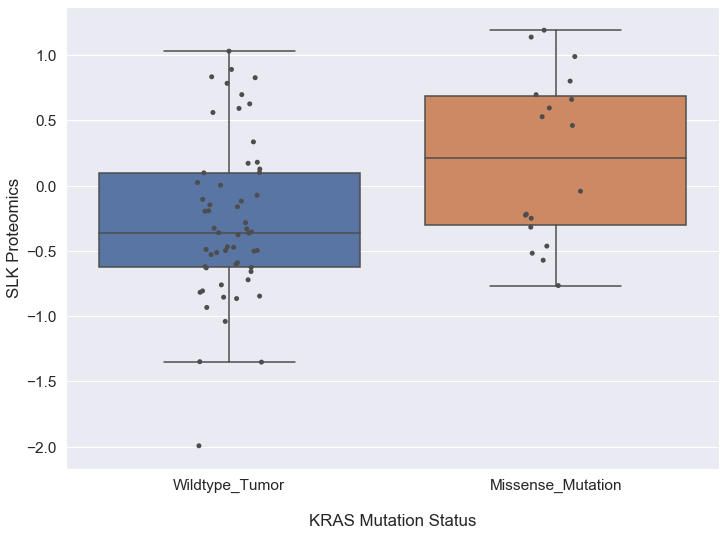

In [64]:

gene = 'SLK'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4)

boxplot = sns.boxplot(x='Mutation', y=gene, data = missense_wt, 
                      #hue = 'Location',
                     # hue_order = ["Wildtype_Tumor", "Missense_Mutation"],
                      showfliers = False)    
#boxplot.set_title('Pancancer cis effect of KRAS Missense')
boxplot = sns.stripplot(x='Mutation', y=gene, data = missense_wt, jitter = True, 
                           color = ".3",
                        # hue = 'Location',
                        #hue_order = ["Wildtype_Tumor", "Missense_Mutation"], 
                        dodge = True)
boxplot.set(xlabel = "\nKRAS Mutation Status", ylabel = gene+' Proteomics')


In [67]:

pval_uncorrected = u.wrap_ttest(missense_wt, 'Mutation', ["SLK"],return_all=True)
pval_uncorrected

,Comparison,P_Value
0,SLK,0.005504


In [69]:
Luad_sig_df = Luad_results.loc[Luad_results['Proteomics'] == "SLK"]
Luad_sig_df

,Proteomics,Luad_P_Value,Luad_Median
229,SLK,0.129044,0.32215
